Import libraries

In [1]:
# libraries
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
#!pip install hmmlearn
#from hmmlearn import hmm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [2]:
# load text files, merge together and convert to lowercase

filename = "hp1.txt"
raw_text = open(filename, 'r', encoding= 'unicode_escape').read()
raw_text = raw_text.lower()

In [3]:
tokenised_text_ = nltk.word_tokenize(raw_text)
len(tokenised_text_)

98823

In [4]:
# tokenise text, assign POS tag to each word
tagged_text_ = nltk.pos_tag(nltk.word_tokenize(raw_text))
len(tagged_text_)

98823

In [5]:
# all possible tags from nltk POS tagger (mapped by me)
nltk_tagset = [('$','dollar'),("''",'quote'),('(','open par'),(')','close par'),
               (',','comma'),('--','dash'),('.','stop mark'),(':','colon'),(';','semi-colon'),
               ('CC','co conj'),('CD','numeral'),('DT','det'),('EX','there'),
               ('FW','foreign'),('IN','sub conj'),('JJ','adj'),('JJR','adj comp'),
               ('JJS','adj sup'),('LS','list item'),('MD','modal'),('NN','noun'),
               ('NNP','prop noun'),('NNPS', 'prop noun pl'),('NNS','noun pl'),
               ('PDT','pre-det'),('POS','genitive'),('PRP','pers pron'),
               ('PRP$','poss pron'),('RB','adv'),('RBR','adv comp'),('RBS','adv sup'),
               ('RP','particle'),('SYM','symbol'),('TO','to'),('UH','interj'),
               ('VB','verb base'),('VBD','verb past'),('VBG','gerund'),('VBN','past part'),
               ('VBP','verb pres'),('VBZ','verb pres 3rd'),('WDT','WH-det'),
               ('WP','WH-pron'),('WP$','WH poss'),('WRB','WH-adv'),('``','open quote')]

In [6]:
# word-level tags mapped to phrase-level tags (NP, ADJP, ADVP, PP, VP, PUNCT)
phrase_tagset = [('$','PUNCT'),("''",'PUNCT'),('(','PUNCT'),(')','PUNCT'),
               (',','PUNCT'),('--','PUNCT'),('.','PUNCT'),(':','PUNCT'),(';','PUNCT'),
               ('CC','PUNCT'),('CD','NP'),('DT','NP'),('EX','VP'),
               ('FW','PUNCT'),('IN','PP'),('JJ','ADJP'),('JJR','ADJP'),
               ('JJS','ADJP'),('LS','PUNCT'),('MD','VP'),('NN','NP'),
               ('NNP','NP'),('NNPS', 'NP'),('NNS','NP'),
               ('PDT','NP'),('POS','ADJP'),('PRP','NP'),
               ('PRP$','NP'),('RB','ADVP'),('RBR','ADVP'),('RBS','ADVP'),
               ('RP','NP'),('SYM','PUNCT'),('TO','PP'),('UH','PUNCT'),
               ('VB','VP'),('VBD','VP'),('VBG','VP'),('VBN','VP'),
               ('VBP','VP'),('VBZ','VP'),('WDT','NP'),
               ('WP','NP'),('WP$','ADJP'),('WRB','ADVP'),('``','PUNCT')]

In [7]:
# get text tagged with phrase tags

phrase_text_ = []
temp_tagset = np.array(phrase_tagset).reshape(len(phrase_tagset),2)
for t in range(len(tagged_text_)):
  ix = np.where(temp_tagset[:,0] == tagged_text_[t][1])[0][0]
  phrase_text_.append((tokenised_text_[t],temp_tagset[ix,1]))

In [8]:
# log likelihood and perplexity for model evaluation

def logLikelihood(N,P):
  return np.sum(np.multiply(N,np.log(P)))

def perplexity(p,n):
  return np.exp(-p/n)

Extract samples of text

In [9]:
# for each sample size, get 5 short samples of text
sizes = [100,200,300,500]
n_samples = 5
groups = []

for size in sizes:
  subsamples = []
  for s in range(n_samples):
    start = np.random.randint(0,len(phrase_text_)-size)
    ss = phrase_text_[start:start+size]
    subsamples.append(ss)
  groups.append(subsamples)

In [10]:
# for each subsample (n_sizes*n_samples)
# for each distinct word, save positions where it occurs in the original text
groups_word_pos = []
groups_count_bigrams = []
groups_bigrams = []

for g in tqdm(range(len(groups))): # for each size
  
  pos_size = []
  n_size = []
  bigr_size = []
  
  for s in range(n_samples): # for all samples of that size
    
    # format sample
    subsample_ = groups[g][s] # select
    temp = np.array(subsample_).reshape(len(subsample_),2)
    subsample = temp[:,0] # sampled sequence of words
    subsample_cl = temp[:,1] # sampled sequence of classes
    uniques = list(np.unique(subsample)) # list of unique words
    classes = list(np.unique(subsample_cl)) # list of unique classes

    # word positions
    word_pos = []
    for match in uniques:
      row = []
      for w_ix, w in enumerate(subsample):
        if w == match: row.append(w_ix)
      word_pos.append(row)
    pos_size.append(word_pos)
    
    # count bigrams
    n = []
    for w_ix, w_to in enumerate(uniques): # for each distinct word
      curr_list = word_pos[w_ix]
      row = [] # make new row
      total_ct = 0.0 # init row total
      for w_from in uniques: # check all the words
        ct = 0.0 # init in-row word count
        for i in range(len(curr_list)): # find loc of current word and look at next word
          if curr_list[i] > 1 and subsample[curr_list[i]-1] == w_from: ct+=1.0
            # don't look at the first index in the global list; if next word is same as curr word, add 1
        row.append(ct) # append current count to row count
      n.append(np.array(row)) # append row count to current row
    n_size.append(n)

    # enumerate bigrams
    bigrams = []
    for i in range(len(subsample)-1):
      bigrams.append([subsample[i],subsample[i+1]])
    bigr_size.append(bigrams)
  
  # append results of the current size to global list
  groups_word_pos.append(pos_size)
  groups_count_bigrams.append(n_size)
  groups_bigrams.append(bigr_size)

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Phrase-based initialisation of P1 and P2 matrices

In [11]:
# initialise p1 and p2 with 6 phrase-level classes
p1_g, p2_g, p_g = [], [], []
logs_g, perplexities_g = [], []

for g in tqdm(range(len(groups))): # for each size
  
  p1s = [] # p(w|c)
  p2s = [] # p(c|w)
  ps = [] # p(w2|w1)
  lls = [] # log-likelihoods
  pps = [] # perplexities
  
  for s in range(n_samples): # for all samples of that size
    
    # format sample
    subsample_ = groups[g][s] # select sample
    word_pos = groups_word_pos[g][s] # select associated word_pos
    n = groups_count_bigrams[g][s] # select associated bigram counts

    temp = np.array(subsample_).reshape(len(subsample_),2)
    subsample = temp[:,0] # sampled sequence of words
    subsample_cl = temp[:,1] # sampled sequence of classes
    uniques = list(np.unique(subsample)) # list of unique words
    classes = ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP']
    #list(np.unique(subsample_cl)) # list of unique classes

    # compute p2
    n_classes = len(classes) # ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP']
    
    p2 = np.zeros((n_classes,len(uniques)))

    for iw, _ in enumerate(uniques): # for each distinct word
      curr_poss = word_pos[iw] # check positions of this word in the sampled text
      for pos in curr_poss: # each time I see this word
        tag = subsample_cl[pos] # take corresponding tag
        for ic, _ in enumerate(classes): # check to which class this tag belongs
          if classes[ic] == tag:
            #print(iw,ic)
            p2[ic,iw] += 1 # add one to corresponding class

    # normalise to get frequency counts
    sum_of_rows = p2.sum(axis=1)
    p2 = p2 / sum_of_rows[:, np.newaxis] # p(c|w)

    # compute p1
    p1 = np.zeros((len(uniques),n_classes))

    for iw, _ in enumerate(uniques): # for each distinct word
      curr_poss = word_pos[iw] # check positions of this word in the sampled text
      for pos in curr_poss: # each time I see this word
        tag = subsample_cl[pos-1] # take tag of previous word
        ic = classes.index(tag) # take corresponding index
        p1[iw,ic] += 1 # add one to word-to-class pair

    # normalise to get frequency counts
    sum_of_rows = p2.sum(axis=1)
    p2 = p2 / sum_of_rows[:, np.newaxis] # p(w|c)    

    # append
    p1s.append(p1)
    p2s.append(p2)

    # compute p
    p = np.zeros((len(uniques),len(uniques)))
    for w1 in range(len(uniques)):
      for w2 in range(len(uniques)):
        sum = 0.0
        for c in range(n_classes):
          sum += p1[w2,c]*p2[c,w1]
        p[w2,w1] = sum

    # assign pairs with zero probability 1/n_distinct_bigrams probability to avoid taking the log of 0 values
    Nb = np.count_nonzero(np.unique(bigrams))
    p[p == 0.0] = 1/Nb

    # append
    ps.append(p)

    # compute initial indices
    ll = logLikelihood(n,p)
    pp = perplexity(ll,Nb)
    lls.append(ll)
    pps.append(pp)
  
  # append to global list
  p1_g.append(p1s)
  p2_g.append(p2s)
  p_g.append(ps)
  logs_g.append(lls)
  perplexities_g.append(pps)

100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


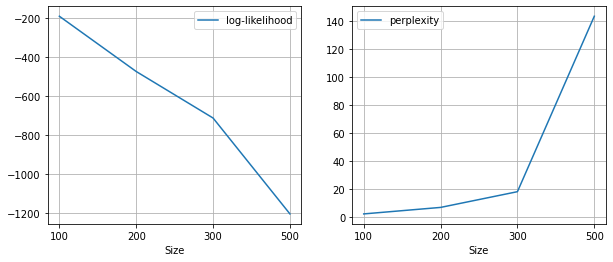

In [45]:
# initial log-likelihoods and perplexities
avg_logs = []
avg_perp = []
for g in range(len(groups)):
  avg_logs.append(np.mean(logs_g[g]))
  avg_perp.append(np.mean(perplexities_g[g]))

#print(avg_logs)
#print(avg_perp)

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(groups)), avg_logs, label='log-likelihood')
plt.xticks(np.arange(len(groups)), labels=['100','200','300','500'])
plt.xlabel('Size')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(len(groups)), avg_perp, label='perplexity')
plt.xticks(np.arange(len(groups)), labels=['100','200','300','500'])
plt.xlabel('Size')
plt.legend()
plt.grid()
plt.show()

In [13]:
# EM algorithm

# for each sample text, save result of 5 EM iterations for loglikelihood, perplexity and p1, p2 matrices
group_logls = []
group_perplexities = []
group_ps = []
n_iters = 5

for g in range(len(groups)):
  
  print('Enter groups of size {}'.format(sizes[g]))

  logs_size = []
  perpl_size = []
  ps_size = []

  for s in range(n_samples):

    print('Start iterations for sample {}'.format(s))

    logLs = []
    perpls = []
    p12 = []

    # format sample
    subsample_ = groups[g][s] # select sample text
    word_pos = groups_word_pos[g][s] # select associated word_pos
    n = groups_count_bigrams[g][s] # select associated bigram counts
    bigrams = groups_bigrams[g][s] # select associated bigram list
    p1 = p1_g[g][s] # select associated initial p1
    p2 = p2_g[g][s] # select associated initial p2

    temp = np.array(subsample_).reshape(len(subsample_),2)
    subsample = temp[:,0] # sampled sequence of words
    subsample_cl = temp[:,1] # sampled sequence of classes
    uniques = list(np.unique(subsample)) # list of unique words
    classes = ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP'] 
    # list(np.unique(subsample_cl)) # list of unique classes

    pE = np.zeros((n_classes,len(bigrams)))

    # iterate EM algorithm for n_iters times
    for iter in tqdm(range(n_iters)):

      # perform E step (eq.2)
      for ib,b in enumerate(bigrams): # get this bigram from sampled text    
          word1 = b[0] # word w1
          word2 = b[1] # word w2
          w1 = uniques.index(word1) # index of w1 in uniques
          w2 = uniques.index(word2) # index of w2 in uniques

          # denominator, same for all classes with this bigram
          den = 0.0
          for ic_,_ in enumerate(classes): # loop over classes
            den += p1[w2,ic_]*p2[ic_,w1] # add to den

          # numerator, one for each class with this bigram
          for ic,_ in enumerate(classes): # get this class
            num = p1[w2,ic]*p2[ic,w1]
            if num > 0: # avoid dividing by 0. if num > 0, then den > 0
              pE[ic,ib] = num/den
            else: pE[ic,ib] = 0.0
          
      # perform M step

      # update p1 (eq.4)
      for ic,_ in enumerate(classes): # loop over classes

        # denominator, same for all words in this class
        den = 0.0 
        for i1,w1 in enumerate(uniques): # get first word
          for i2,w2 in enumerate(uniques): # get second word
            if [w1,w2] in bigrams: # if it is a valid bigram
              b = bigrams.index([w1,w2]) # take index of corresponding bigram
              den += n[i2][i1]*pE[ic,b] # add to denominator

        # numerator, one for each word in this class
        for i2,w2 in enumerate(uniques): # get this word
          num = 0.0
          for i1,w1 in enumerate(uniques): # get second word
            if [w1,w2] in bigrams: # if it is a valid bigram
              b = bigrams.index([w1,w2]) # take index of corresponding bigram
              num += n[i2][i1]*pE[ic,b] # add to numerator
          # compute probability
          if num > 0:
            p1[i2,ic] = num/den
          else: p1[i2,ic] = 0.0

      # update p2 (eq.3)
      for i1,w1 in enumerate(uniques): # get this word
      
        # denominator, same for all classes with this word
        den = 0.0
        for i2,w2 in enumerate(uniques): # get second word
          if [w1,w2] in bigrams: # if it is a valid bigram
            b = bigrams.index([w1,w2]) # index of corresponding bigram
            for ic_, _ in enumerate(classes): # for each class
              den += n[i2][i1]*pE[ic_,b] # add to den

        # numerator, one for each class with this word
        for ic,_ in enumerate(classes): # for each class
          num = 0.0
          for i2,w2 in enumerate(uniques): # get second word
            if [w1,w2] in bigrams: # if it is a valid bigram
              b = bigrams.index([w1,w2]) # index of corresponding bigram
              num += n[i2][i1]*pE[ic,b]
          # compute probability
          if num > 0:
            p2[ic,i1] = num/den
          else: p2[ic,i1] = 0.0

      # compute p
      p = np.zeros((len(uniques),len(uniques)))
      for w1 in range(len(uniques)):
        for w2 in range(len(uniques)):
          sum = 0.0
          for c in range(n_classes):
            sum += p1[w2,c]*p2[c,w1]
          p[w2,w1] = sum

      # assign pairs with zero probability 1/n_distinct_bigrams probability to avoid taking the log of 0 values
      Nb = np.count_nonzero(np.unique(bigrams))
      p[p == 0.0] = 1/Nb

      # compute indices
      ll = logLikelihood(n,p)
      pp = perplexity(ll,Nb)
      logLs.append(ll)
      perpls.append(pp)
      p12.append([p1,p2])
    
    # append to sample-level results
    logs_size.append(logLs)
    perpl_size.append(perpls)
    ps_size.append(p12)

  print('')
  # append to global list
  group_logls.append(logs_size)
  group_perplexities.append(perpl_size)
  group_ps.append(ps_size) # #4 groups -> #5 samples -> #5 iterations -> #2 matrices (p1,p2)
  # e.g. group_ps[3][0][4][0] is p1 at 5th iteration of sample 1 of size 500
  # e.g. group_ps[3][0][4][1] is p2 at 5th iteration of sample 1 of size 500

Enter groups of size 100
Start iterations for sample 0


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Start iterations for sample 1


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Start iterations for sample 2


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Start iterations for sample 3


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Start iterations for sample 4


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



Enter groups of size 200
Start iterations for sample 0


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Start iterations for sample 1


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Start iterations for sample 2


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Start iterations for sample 3


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Start iterations for sample 4


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]



Enter groups of size 300
Start iterations for sample 0


100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


Start iterations for sample 1


100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


Start iterations for sample 2


100%|██████████| 5/5 [00:26<00:00,  5.25s/it]


Start iterations for sample 3


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Start iterations for sample 4


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]



Enter groups of size 500
Start iterations for sample 0


100%|██████████| 5/5 [01:20<00:00, 16.20s/it]


Start iterations for sample 1


100%|██████████| 5/5 [01:09<00:00, 13.88s/it]


Start iterations for sample 2


100%|██████████| 5/5 [00:56<00:00, 11.35s/it]


Start iterations for sample 3


100%|██████████| 5/5 [01:04<00:00, 12.94s/it]


Start iterations for sample 4


100%|██████████| 5/5 [01:25<00:00, 17.18s/it]

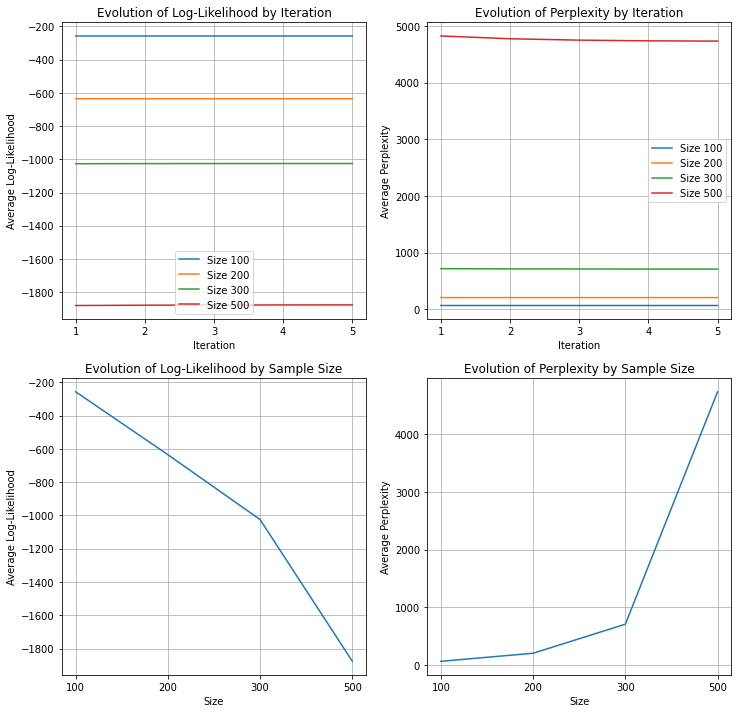

In [14]:
# plot indices against iterations
# for each size, take average value of metrics at each iteration
# plot has iteration on x axis, metrics on y axis. one plot for each size
avg_logs_EM = []
avg_perp_EM = []
for g in range(len(groups)):
  group_ll = []
  group_pp = []
  for iter in range(n_iters):
    group_ll.append(np.mean(np.array(group_logls[g])[:,iter]))
    group_pp.append(np.mean(np.array(group_perplexities[g])[:,iter]))
  avg_logs_EM.append(group_ll)
  avg_perp_EM.append(group_pp)

fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
for i in range(len(avg_logs_EM)):
  plt.plot(np.arange(n_iters), avg_logs_EM[i], label='Size {}'.format(sizes[i]))
plt.title('Evolution of Log-Likelihood by Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Log-Likelihood')
plt.xticks([0,1,2,3,4],labels=[1,2,3,4,5])
plt.legend()
plt.grid()

plt.subplot(2,2,2)
for i in range(len(avg_perp_EM)):
  plt.plot(np.arange(n_iters), avg_perp_EM[i], label='Size {}'.format(sizes[i]))
plt.title('Evolution of Perplexity by Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Perplexity')
plt.xticks([0,1,2,3,4],labels=[1,2,3,4,5])
plt.legend()
plt.grid()

# plot indices against size
# for each size group, take average value of n-th iterations (the last)
# plot has size on x axis, metrics on y axis.
size_ll = []
size_pp = []
for g in range(len(groups)):
  size_ll.append(np.mean(np.array(group_logls[g])[:,-1]))
  size_pp.append(np.mean(np.array(group_perplexities[g])[:,-1]))

plt.subplot(2,2,3)
plt.plot(np.arange(len(groups)), size_ll)
plt.xticks(np.arange(len(groups)),labels=[100,200,300,500])
plt.title('Evolution of Log-Likelihood by Sample Size')
plt.xlabel('Size')
plt.ylabel('Average Log-Likelihood')
plt.grid()

plt.subplot(2,2,4)
plt.plot(np.arange(len(groups)), size_pp)
plt.xticks(np.arange(len(groups)),labels=[100,200,300,500])
plt.title('Evolution of Perplexity by Sample Size')
plt.xlabel('Size')
plt.ylabel('Average Perplexity')
plt.grid()
plt.show()

Random initialisation of P1 and P2 matrices with different numbers of classes

In [15]:
# try classes [2,4,6,12]
# I initialise p1, p2 for each subsample and record initial values of log-likelihood and perplexity

number_of_classes = [2,4,6,12]
class_p1 = []
class_p2 = []
class_ls = []
class_ps = []

for n_classes in number_of_classes:

  # initialise p1 and p2 with n random classes
  p1_r, p2_r, p_r = [], [], []
  logs_r, perplexities_r = [], []

  for g in range(len(groups)): # for each size

    p1s = [] # p(w|c)
    p2s = [] # p(c|w)
    ps = [] # p(w2|w1)
    lls = [] # log-likelihoods
    pps = [] # perplexities
    
    for s in range(n_samples): # for all samples of that size
      
      subsample_ = groups[g][s]
      bigrams = groups_bigrams[g][s]
      n = groups_count_bigrams[g][s]
      temp = np.array(subsample_).reshape(len(subsample_),2)
      subsample = temp[:,0] # sampled sequence of words
      uniques = list(np.unique(subsample)) # list of unique words

      bigrams = groups_bigrams[g][s]

      p1 = np.zeros((len(uniques),n_classes))
      p2 = np.zeros((n_classes,len(uniques)))

      # random uniform
      for i in range(n_classes): # p1
        row = random.sample(range(0, 1000), len(uniques))
        tot = np.sum(row)
        p1[:,i] = row/tot

      for i in range(len(uniques)): # p2
        row = random.sample(range(0, 1000), n_classes)
        tot = np.sum(row)
        p2[:,i] = row/tot

      # append
      p1s.append(p1)
      p2s.append(p2)

      # compute p
      p = np.zeros((len(uniques),len(uniques)))
      for w1 in range(len(uniques)):
        for w2 in range(len(uniques)):
          sum = 0.0
          for c in range(n_classes):
            sum += p1[w2,c]*p2[c,w1]
          p[w2,w1] = sum

      # assign pairs with zero probability 1/n_distinct_bigrams probability to avoid taking the log of 0 values
      Nb = np.count_nonzero(np.unique(bigrams))
      p[p == 0.0] = 1/Nb

      # append
      ps.append(p)

      # compute initial indices
      ll = logLikelihood(n,p)
      pp = perplexity(ll,Nb)
      lls.append(ll)
      pps.append(pp)
    
    # append to global list
    p1_r.append(p1s)
    p2_r.append(p2s)
    p_r.append(ps)
    logs_r.append(lls)
    perplexities_r.append(pps)
  
  # append to class list
  class_p1.append(p1_r)
  class_p2.append(p2_r)
  class_ls.append(logs_r)
  class_ps.append(perplexities_r)

In [16]:
# EM algorithm

group_class_ls = []
group_class_ps = []
group_class_transP = []

for cs,n_classes in enumerate(number_of_classes): # select number of classes

  print('Enter model with {} classes'.format(n_classes))

  # for each sample text, save result of 5 EM iterations for loglikelihood and perplexity
  rgroup_logls = []
  rgroup_perplexities = []
  rgroup_ps = []
  n_iters = 7

  for g in range(len(groups)): # select size
    
    print('Enter groups of size {}'.format(sizes[g]))

    logs_size = []
    perpl_size = []
    p_size = []

    for s in tqdm(range(n_samples)): # select sample

      #print('Start iterations for sample {}'.format(s))

      logLs = []
      perpls = []
      ps = []

      # format sample
      subsample_ = groups[g][s] # select sample text
      word_pos = groups_word_pos[g][s] # select associated word_pos
      n = groups_count_bigrams[g][s] # select associated bigram counts
      bigrams = groups_bigrams[g][s] # select associated bigram list
      p1 = class_p1[cs][g][s] # select associated initial p1
      p2 = class_p2[cs][g][s] # select associated initial p2

      temp = np.array(subsample_).reshape(len(subsample_),2)
      subsample = temp[:,0] # sampled sequence of words
      uniques = list(np.unique(subsample)) # list of unique words

      pE = np.zeros((n_classes,len(bigrams)))

      # iterate EM algorithm for n_iters times
      for iter in range(n_iters): # select iter

        # perform E step (eq.2)
        for ib,b in enumerate(bigrams): # get this bigram from sampled text    
            word1 = b[0] # word w1
            word2 = b[1] # word w2
            w1 = uniques.index(word1) # index of w1 in uniques
            w2 = uniques.index(word2) # index of w2 in uniques

            # denominator, same for all classes with this bigram
            den = 0.0
            for ic_ in range(n_classes): # loop over classes
              den += p1[w2,ic_]*p2[ic_,w1] # add to den

            # numerator, one for each class with this bigram
            for ic in range(n_classes): # get this class
              num = p1[w2,ic]*p2[ic,w1]
              if num > 0: # avoid dividing by 0. if num > 0, then den > 0
                pE[ic,ib] = num/den
              else: pE[ic,ib] = 0.0
            
        # perform M step

        # update p1 (eq.4)
        for ic in range(n_classes): # loop over classes

          # denominator, same for all words in this class
          den = 0.0 
          for i1,w1 in enumerate(uniques): # get first word
            for i2,w2 in enumerate(uniques): # get second word
              if [w1,w2] in bigrams: # if it is a valid bigram
                b = bigrams.index([w1,w2]) # take index of corresponding bigram
                den += n[i2][i1]*pE[ic,b] # add to denominator

          # numerator, one for each word in this class
          for i2,w2 in enumerate(uniques): # get this word
            num = 0.0
            for i1,w1 in enumerate(uniques): # get second word
              if [w1,w2] in bigrams: # if it is a valid bigram
                b = bigrams.index([w1,w2]) # take index of corresponding bigram
                num += n[i2][i1]*pE[ic,b] # add to numerator
            # compute probability
            if num > 0:
              p1[i2,ic] = num/den
            else: p1[i2,ic] = 0.0

        # update p2 (eq.3)
        for i1,w1 in enumerate(uniques): # get this word
        
          # denominator, same for all classes with this word
          den = 0.0
          for i2,w2 in enumerate(uniques): # get second word
            if [w1,w2] in bigrams: # if it is a valid bigram
              b = bigrams.index([w1,w2]) # index of corresponding bigram
              for ic_ in range(n_classes): # for each class
                den += n[i2][i1]*pE[ic_,b] # add to den

          # numerator, one for each class with this word
          for ic in range(n_classes): # for each class
            num = 0.0
            for i2,w2 in enumerate(uniques): # get second word
              if [w1,w2] in bigrams: # if it is a valid bigram
                b = bigrams.index([w1,w2]) # index of corresponding bigram
                num += n[i2][i1]*pE[ic,b]
            # compute probability
            if num > 0:
              p2[ic,i1] = num/den
            else: p2[ic,i1] = 0.0

        # compute p
        p = np.zeros((len(uniques),len(uniques)))
        for w1 in range(len(uniques)):
          for w2 in range(len(uniques)):
            sum = 0.0
            for c in range(n_classes):
              sum += p1[w2,c]*p2[c,w1]
            p[w2,w1] = sum

        # assign pairs with zero probability 1/n_distinct_bigrams probability to avoid taking the log of 0 values
        Nb = np.count_nonzero(np.unique(bigrams))
        p[p == 0.0] = 1/Nb

        # compute indices
        ll = logLikelihood(n,p)
        pp = perplexity(ll,Nb)
        logLs.append(ll)
        perpls.append(pp)
        ps.append([p1,p2])
      
      # append to sample-level results
      logs_size.append(logLs)
      perpl_size.append(perpls)
      p_size.append(ps)

    # append to global list
    rgroup_logls.append(logs_size)
    rgroup_perplexities.append(perpl_size)
    rgroup_ps.append(p_size)

  # append to class list
  group_class_ls.append(rgroup_logls)
  group_class_ps.append(rgroup_perplexities)
  group_class_transP.append(rgroup_ps)
  print("")

Enter model with 2 classes
Enter groups of size 100


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Enter groups of size 200


100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Enter groups of size 300


100%|██████████| 5/5 [00:56<00:00, 11.23s/it]


Enter groups of size 500


100%|██████████| 5/5 [03:03<00:00, 36.77s/it]



Enter model with 4 classes
Enter groups of size 100


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Enter groups of size 200


100%|██████████| 5/5 [00:41<00:00,  8.22s/it]


Enter groups of size 300


100%|██████████| 5/5 [01:43<00:00, 20.75s/it]


Enter groups of size 500


100%|██████████| 5/5 [05:40<00:00, 68.17s/it]



Enter model with 6 classes
Enter groups of size 100


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Enter groups of size 200


100%|██████████| 5/5 [00:59<00:00, 11.91s/it]


Enter groups of size 300


100%|██████████| 5/5 [02:30<00:00, 30.06s/it]


Enter groups of size 500


100%|██████████| 5/5 [08:15<00:00, 99.09s/it] 



Enter model with 12 classes
Enter groups of size 100


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


Enter groups of size 200


100%|██████████| 5/5 [01:55<00:00, 23.12s/it]


Enter groups of size 300


100%|██████████| 5/5 [04:52<00:00, 58.58s/it]


Enter groups of size 500


100%|██████████| 5/5 [16:02<00:00, 192.59s/it]

In [17]:
# classes, group, sample, iters

# perplexity
pps = []
for sz,size in enumerate(sizes): # [100,200,300,500]
  ss = []
  for cl,cls in enumerate(number_of_classes): # [1,2,4,6,12]
    ss.append(np.mean(np.array(group_class_ps[cl][sz])[:,-1]))
  pps.append(ss)

# log-likelihood
lls = []
for sz,size in enumerate(sizes): # [100,200,300,500]
  ss = []
  for cl,cls in enumerate(number_of_classes): # [1,2,4,6,12]
    ss.append(np.mean(np.array(group_class_ls[cl][sz])[:,-1]))
  lls.append(ss)

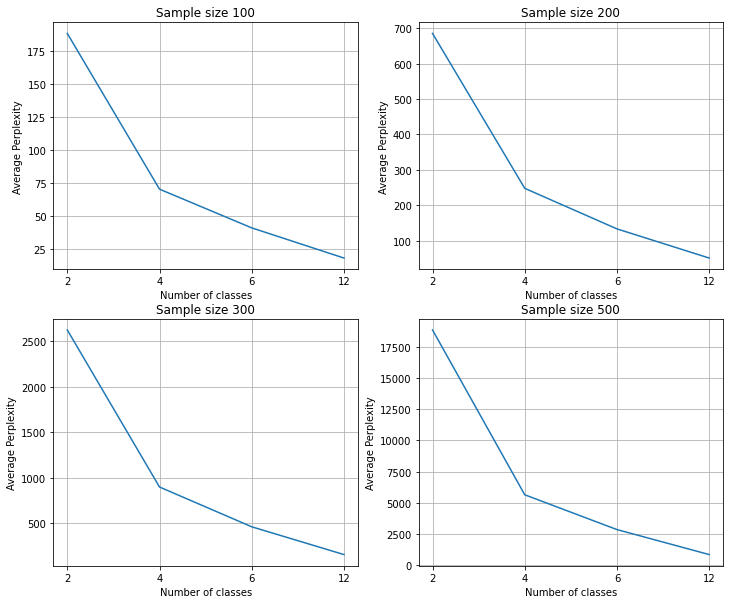

In [27]:
x = np.arange(len(number_of_classes))

fig = plt.figure(figsize=(12,10))

for sz in range(len(sizes)):
  plt.subplot(2,2,sz+1)
  plt.plot(x, pps[sz])
  plt.xticks(x, labels=number_of_classes)
  plt.title('Sample size {}'.format(sizes[sz]))
  plt.ylabel('Average Perplexity')
  plt.xlabel('Number of classes')
  plt.grid()

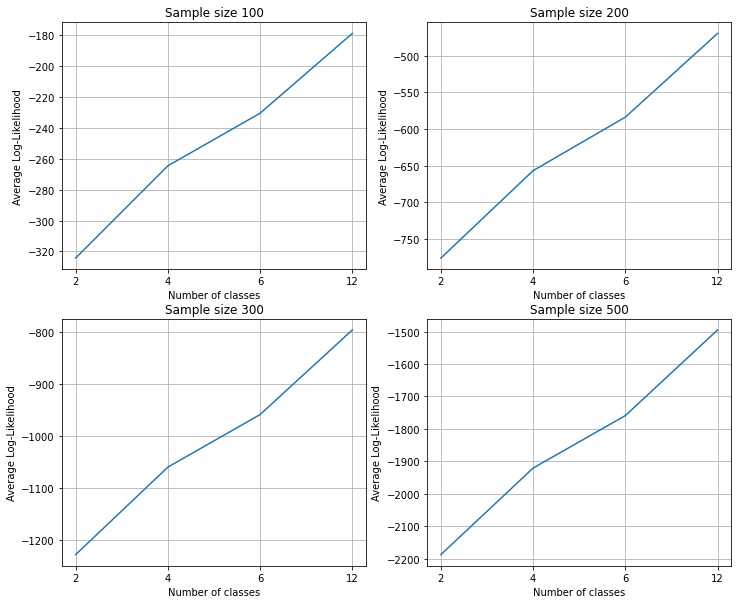

In [26]:
x = np.arange(len(number_of_classes))

fig = plt.figure(figsize=(12,10))

for sz in range(len(sizes)):
  plt.subplot(2,2,sz+1)
  plt.plot(x, lls[sz])
  plt.xticks(x, labels=number_of_classes)
  plt.title('Sample size {}'.format(sizes[sz]))
  plt.ylabel('Average Log-Likelihood')
  plt.xlabel('Number of classes')
  plt.grid()

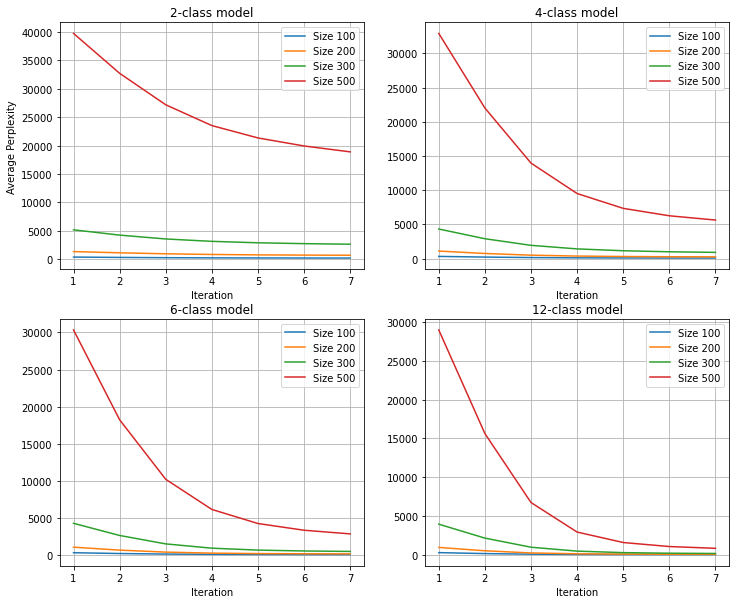

In [25]:
# number of iterations
class_enum = []
for cl in range(len(number_of_classes)):
  class_sizes = []
  for sz in range(len(sizes)):
    size = []
    for iter in range(n_iters):
      size.append(np.mean(np.array(group_class_ps[cl][sz])[:,iter]))
    class_sizes.append(size)
  class_enum.append(class_sizes)
  
fig = plt.figure(figsize=(12,10))
for cl in range(len(number_of_classes)):
  plt.subplot(2,2,cl+1)
  for sz in range(len(sizes)):
    plt.plot(range(1,n_iters+1), class_enum[cl][sz], label='Size {}'.format(sizes[sz]))
  plt.xticks(range(1,n_iters+1))
  plt.title('{}-class model'.format(number_of_classes[cl]))
  plt.xlabel('Iteration')
  if cl==0:
    plt.ylabel('Average Perplexity')
  plt.legend()
  plt.grid()

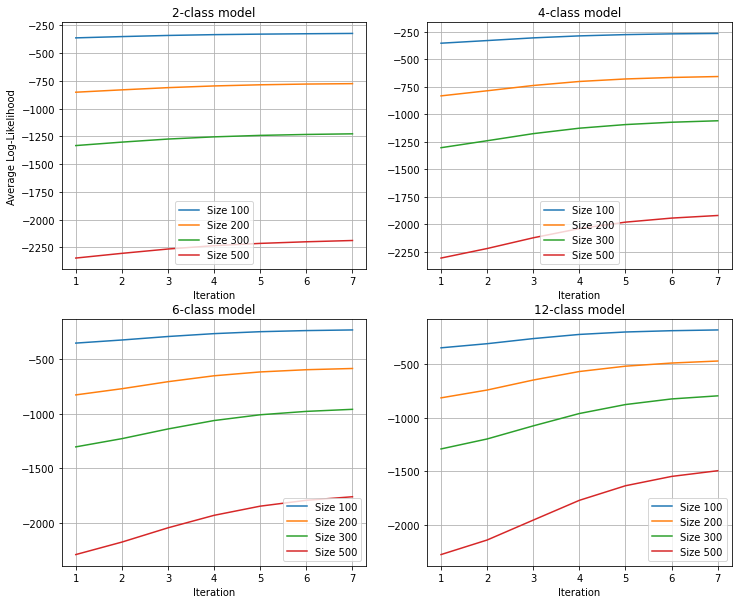

In [28]:
# number of iterations
class_enum = []
for cl in range(len(number_of_classes)):
  class_sizes = []
  for sz in range(len(sizes)):
    size = []
    for iter in range(n_iters):
      size.append(np.mean(np.array(group_class_ls[cl][sz])[:,iter]))
    class_sizes.append(size)
  class_enum.append(class_sizes)
  
fig = plt.figure(figsize=(12,10))
for cl in range(len(number_of_classes)):
  plt.subplot(2,2,cl+1)
  for sz in range(len(sizes)):
    plt.plot(range(1,n_iters+1), class_enum[cl][sz], label='Size {}'.format(sizes[sz]))
  plt.xticks(range(1,n_iters+1))
  plt.title('{}-class model'.format(number_of_classes[cl]))
  plt.xlabel('Iteration')
  if cl==0:
    plt.ylabel('Average Log-Likelihood')
  plt.legend()
  plt.grid()

Text generation

In [29]:
# ALGORITHMS with p
# generate class first from p2, then word from p1 using newly generated class
# classes are ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP']

# next word generation
def new_word(t, words, prev_word, p, k, mode):
  
  prev_word_ix = words.index(prev_word)
  weights = p[:,prev_word_ix] # generate from p, p(w2|w1) 
  sum_of_weights = np.sum(weights)
  if sum_of_weights == 0.0:
    weights = np.zeros(p.shape[0]) + 1/p.shape[0]
  
  # indices of top k word choices: if available choices < k, add some random choices
  if mode == 'top-k':
    pos_count = np.count_nonzero(weights > 0)
    if pos_count >= k:
      choices_ix = np.argsort(weights)[-k:]
    elif pos_count != 0 and pos_count < k: 
      add_w = list(random.choices(range(len(words), k=k-pos_count)))
      choices_ix = list(np.argsort(weights)[-pos_count:]) + add_w
    else: choices_ix = random.choices(range(len(words)), k=k)

    print('#{}. Input 0 to stop predicting. Otherwise, pick a word.'.format(t+1))
    print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}'.format(
      words[choices_ix[4]], words[choices_ix[3]], words[choices_ix[2]],
      words[choices_ix[1]], words[choices_ix[0]]))
    
    i = int(input()) # let the user choose
    if i == 0: return 'exit'
    else: return words[choices_ix[k-i]]
  
  # k random weighted options
  elif mode == 'random':
    choices_ix = []
    nonzero_els = np.count_nonzero(weights!=0)
    rest = 0
    k_ = k
    if nonzero_els < k:
      rest = k - nonzero_els
      k_ = nonzero_els
    choices_ix = list(np.random.choice(words, size=k_, p=weights/sum_of_weights, replace=False))
    if rest > 0:
      for r in range(rest):
        choices_ix += list(np.random.choice(words, size=1, p=weights/sum_of_weights, replace=True))
    
    print('#{}. Input 0 to stop predicting. Otherwise, pick a word.'.format(t+1))
    print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}'.format(
      choices_ix[4], choices_ix[3], choices_ix[2],
      choices_ix[1], choices_ix[0]))
    
    i = int(input()) # let the user choose
    if i == 0: return 'exit'
    else: return choices_ix[k-i]

In [30]:
# ALGORITHMS with p1 and p2
# generate class first from p2, then word from p1 using newly generated class
# classes are ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP']

# this state generation
def new_state(t, last_word, words, states, p2, mode):
  
  i = words.index(last_word)
  weights = p2[:,i] # p(c|w)
  sum_of_weights = np.sum(weights)
  
  # print all 6 classes in weighted order
  if mode == 'manual':
    choices_ix = list(np.argsort(weights))

    print('#{}. Input 0 to stop predicting. Otherwise, pick a category:'.format(t+1))
    print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}, 6. {}'.format(
        states[choices_ix[5]], states[choices_ix[4]], states[choices_ix[3]],
        states[choices_ix[2]], states[choices_ix[1]], states[choices_ix[0]]))
    
    i = int(input()) # let the user choose
    
    if i==0: return 'exit'
    else: return states[choices_ix[6-i]]

  # choose one randomly
  elif mode == 'random':
    choice = list(np.random.choice(states, size=1, p=weights/sum_of_weights, replace=True))

    print('#{}. Input 0 to stop predicting. Otherwise, input 1 to get a random class.'.format(t+1))
    
    i = int(input()) # let the user choose
    
    if i==0: return 'exit'
    else: return choice

# next word generation
def new_obs(t, states, words, prev_state, p1, k, mode):
  
  prev_state_ix = states.index(prev_state)
  weights = p1[:,prev_state_ix] # generate from p1, p(w|c) 
  sum_of_weights = np.sum(weights)

  
  # indices of top k word choices: if available choices < k, add some random choices
  if mode == 'top-k':
    pos_count = np.count_nonzero(weights > 0)
    if pos_count >= k:
      choices_ix = np.argsort(weights)[-k:]
    elif pos_count != 0 and pos_count < k: 
      add_w = list(random.choices(range(len(words), k=k-pos_count)))
      choices_ix = list(np.argsort(weights)[-pos_count:]) + add_w
    else: choices_ix = random.choices(range(len(words)), k=k)

    print('#{}. Pick a word.'.format(t+1))
    print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}'.format(
      words[choices_ix[4]], words[choices_ix[3]], words[choices_ix[2]],
      words[choices_ix[1]], words[choices_ix[0]]))
    
    i = int(input()) # let the user choose
    if i == 0: return '.'
    else: return words[choices_ix[k-i]]
  
  # k random weighted options
  elif mode == 'random':
    choices_ix = []
    nonzero_els = np.count_nonzero(weights!=0)
    rest = 0
    k_ = k
    if nonzero_els < k:
      rest = k - nonzero_els
      k_ = nonzero_els
    choices_ix = list(np.random.choice(words, size=k_, p=weights/sum_of_weights, replace=False))
    if rest > 0:
      for r in range(rest):
        choices_ix += list(np.random.choice(words, size=1, p=weights/sum_of_weights, replace=True))
    
    print('#{}. Pick a word.'.format(t+1))
    print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}'.format(
      choices_ix[4], choices_ix[3], choices_ix[2],
      choices_ix[1], choices_ix[0]))
    
    i = int(input()) # let the user choose
    if i == 0: return '.'
    else: return choices_ix[k-i]

In [31]:
# set starting observation

# input sentence from the user
words_seed = nltk.word_tokenize('harry was')
print('Starting sequence of words:')
print(words_seed)

Starting sequence of words:
['harry', 'was']


In [62]:
# group_ps[3][0][4][0] is p1 at 5th iteration of sample 1 of size 500
# classes ['ADJP', 'ADVP', 'NP', 'PP', 'PUNCT', 'VP']

# try running some predictions
pred_length = 20
new_states = []
new_obss = []
prev_word = words_seed[-1]
p1_ = group_ps[3][0][4][0] # using phrase-based classes
p2_ = group_ps[3][0][4][1] # using phrase-based classes
#p2_ = group_class_transP[3][3][0][6][1] # using random classes
#p1_ = group_class_transP[3][3][0][6][0] # using random classes
uniques_ = list(np.unique(np.array(groups[3][0]).reshape(len(groups[3][0]),2)[:,0])) # get list of unique words in this text

In [64]:
# predict using p1 and p2

exit = False
t = 1
while exit == False and t < pred_length: # provide a way to stop predictions at any given point
    new_s = new_state(t, prev_word, uniques_, classes, p2_, 'manual')
    if new_s == 'exit': 
      exit = True
      break
    new_states.append(new_s)
    new_o = new_obs(t, classes, uniques_, new_s, p1_, 5, 'random')
    new_obss.append(new_o)
    prev_state = new_s
    prev_word = new_o
    t = t+1

#2. Input 0 to stop predicting. Otherwise, pick a category:
1. VP, 2. PUNCT, 3. PP, 4. NP, 5. ADVP, 6. ADJP
1
#2. Pick a word.
1. a, 2. ambling, 3. bought, 4. ,, 5. us
1
#3. Input 0 to stop predicting. Otherwise, pick a category:
1. NP, 2. VP, 3. PUNCT, 4. PP, 5. ADVP, 6. ADJP
1
#3. Pick a word.
1. ., 2. of, 3. ,, 4. mother, 5. rations
1
#4. Input 0 to stop predicting. Otherwise, pick a category:
1. PUNCT, 2. VP, 3. PP, 4. NP, 5. ADVP, 6. ADJP
4
#4. Pick a word.
1. week, 2. --, 3. car, 4. ley, 5. ,
3
#5. Input 0 to stop predicting. Otherwise, pick a category:
1. NP, 2. VP, 3. PUNCT, 4. PP, 5. ADVP, 6. ADJP
1
#5. Pick a word.
1. made, 2. could, 3. was, 4. garage, 5. 'd
4
#6. Input 0 to stop predicting. Otherwise, pick a category:
1. NP, 2. VP, 3. PUNCT, 4. PP, 5. ADVP, 6. ADJP
2
#6. Pick a word.
1. smiling, 2. somewhere, 3. on, 4. to, 5. .
3
#7. Input 0 to stop predicting. Otherwise, pick a category:
1. PP, 2. VP, 3. PUNCT, 4. NP, 5. ADVP, 6. ADJP
4
#7. Pick a word.
1. ., 2. head, 3. ,,

In [65]:
print(' '.join(words_seed + new_obss))

harry was a . car garage on birthdays already on . dully clapping gentleman parked package there and again


In [67]:
# Predict using p only
# compute p
n_classes = 6
p = np.zeros((len(uniques_),len(uniques_)))
for w1 in range(len(uniques_)):
  for w2 in range(len(uniques_)):
    sum = 0.0
    for c in range(n_classes):
      sum += p1_[w2,c]*p2_[c,w1]
    p[w2,w1] = sum

new_words = []
exit = False
t = 1
while exit == False and t < pred_length: # provide a way to stop predictions at any given point
  new_w = new_word(t, uniques_, prev_word, p, 5, 'random')
  if new_w == 'exit': 
    exit = True
    break
  new_words.append(new_w)
  prev_word = new_w
  t = t+1

#2. Input 0 to stop predicting. Otherwise, pick a word.
1. vernon, 2. iron-gray, 3. out, 4. for, 5. ,
3
#3. Input 0 to stop predicting. Otherwise, pick a word.
1. !, 2. know, 3. said, 4. the, 5. uncle
4
#4. Input 0 to stop predicting. Otherwise, pick a word.
1. and, 2. ., 3. garage, 4. ,, 5. had
3
#5. Input 0 to stop predicting. Otherwise, pick a word.
1. did, 2. head, 3. of, 4. ,, 5. boat
4
#6. Input 0 to stop predicting. Otherwise, pick a word.
1. clapping, 2. i, 3. this, 4. standing, 5. ``
4
#7. Input 0 to stop predicting. Otherwise, pick a word.
1. monday, 2. to, 3. smiling, 4. ., 5. again
5
#8. Input 0 to stop predicting. Otherwise, pick a word.
1. eleven, 2. miserable, 3. and, 4. ., 5. to
4
#9. Input 0 to stop predicting. Otherwise, pick a word.
1. his, 2. clapping, 3. '', 4. a, 5. following
4
#10. Input 0 to stop predicting. Otherwise, pick a word.
1. asked, 2. 's, 3. old, 4. stared, 5. vernon
5
#11. Input 0 to stop predicting. Otherwise, pick a word.
1. and, 2. ,, 3. said, 4. w

In [68]:
print(' '.join(words_seed + new_words))

harry was out the garage , standing again . a vernon was also carrying harry 's aunt later , uncle had
